In [4]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams.update({'font.size': 16})

import pandas as pd
import numpy as np

In [2]:
field = 'W3'

filename = f'/home/alberto/almacen/PAUS_data/{field}_pointings.csv'
point_info = pd.read_csv(filename)

In [8]:
# Extract unique pointing identifiers
pointing_ids = np.unique(point_info['pointing_id'])

# Compute the mean RA, DEC of the dithering
mean_ra = np.empty_like(pointing_ids)
mean_dec = np.empty_like(pointing_ids)
for i, point_id in enumerate(pointing_ids):
    mean_ra[i] = np.average(point_info['ra'][point_info['pointing_id'] == point_id])
    mean_dec[i] = np.average(point_info['dec'][point_info['pointing_id'] == point_id])

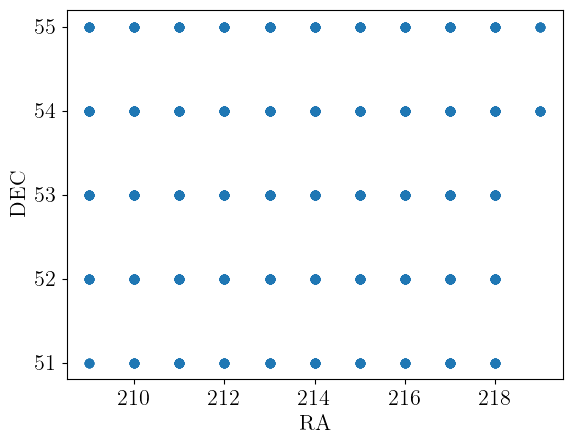

In [10]:
fig, ax = plt.subplots()

ax.scatter(mean_ra, mean_dec)
ax.set(xlabel='RA', ylabel='DEC')

plt.show()

In [38]:
# Load the photometry catalog
from load_paus_cat import load_paus_cat

field_name = 'W3'
path_to_cat = [f'/home/alberto/almacen/PAUS_data/catalogs/PAUS_3arcsec_{field_name}.csv']
cat = load_paus_cat(path_to_cat)

mask_NB_number = (cat['NB_number'] > -1)
cat['flx'] = cat['flx'][:, mask_NB_number]
cat['err'] = cat['err'][:, mask_NB_number]
cat['NB_mask'] = cat['NB_mask'][:, mask_NB_number]
for key in cat.keys():
    if key in ['flx', 'err', 'NB_mask', 'area']:
        continue
    cat[key] = cat[key][mask_NB_number]

stack_nb_ids = np.arange(12, 16 + 1)
synth_BB_flx = np.average(cat['flx'][stack_nb_ids],
                          weights=cat['err'][stack_nb_ids] ** -2,
                          axis=0)

N_sources = len(cat['ref_id'])

In [39]:
# Assign each source the closest pointing center
pointing_id_Arr = np.empty(N_sources)
for src in range(N_sources):
    if not src % 10000:
        print(f'{src} / {N_sources}')
    where_pointing_id_Arr = np.argmin(
        (cat['RA'][src] - mean_ra) ** 2
        + (cat['DEC'][src] - mean_dec) ** 2
    )
    pointing_id_Arr[src] = pointing_ids[where_pointing_id_Arr]

# Save the array
save_path = f'/home/alberto/almacen/PAUS_data/catalogs/pointing_ids_{field_name}'
np.save(save_path, pointing_id_Arr)

0 / 894562
10000 / 894562
20000 / 894562
30000 / 894562
40000 / 894562
50000 / 894562
60000 / 894562
70000 / 894562
80000 / 894562
90000 / 894562
100000 / 894562
110000 / 894562
120000 / 894562
130000 / 894562
140000 / 894562
150000 / 894562
160000 / 894562
170000 / 894562
180000 / 894562
190000 / 894562
200000 / 894562
210000 / 894562
220000 / 894562
230000 / 894562
240000 / 894562
250000 / 894562
260000 / 894562
270000 / 894562
280000 / 894562
290000 / 894562
300000 / 894562
310000 / 894562
320000 / 894562
330000 / 894562
340000 / 894562
350000 / 894562
360000 / 894562
370000 / 894562
380000 / 894562
390000 / 894562
400000 / 894562
410000 / 894562
420000 / 894562
430000 / 894562
440000 / 894562
450000 / 894562
460000 / 894562
470000 / 894562
480000 / 894562
490000 / 894562
500000 / 894562
510000 / 894562
520000 / 894562
530000 / 894562
540000 / 894562
550000 / 894562
560000 / 894562
570000 / 894562
580000 / 894562
590000 / 894562
600000 / 894562
610000 / 894562
620000 / 894562
630000

In [36]:
# from paus_utils import data_tab as fil_properties
# from paus_utils import w_central
# from jpasLAEs.utils import flux_to_mag

# to_plot = np.arange(40)

# fig, ax = plt.subplots(figsize=(6, 4))

# for fil_id in to_plot:
#     # SNR versus magnitude
#     sigma = 5
#     pointing_depth_list = []

#     snr = cat['flx'][fil_id] / cat['err'][fil_id]
#     mag = flux_to_mag(cat['flx'][fil_id], w_central[fil_id])

#     for point_id in pointing_ids:
#         mask = (pointing_id_Arr.astype(int) == point_id)
#         if sum(mask) == 0:
#             pointing_depth_list.append(0)
#             continue
        
#         depth = np.median(mag[mask & (np.abs(snr - 5) < 0.1)])
#         pointing_depth_list.append(depth)

#     ax.scatter(pointing_ids, pointing_depth_list,
#                label=fil_properties['name'][fil_id])

#     fil_properties['name']

# ax.set_ylim(20, 24)
# ax.legend(fontsize=10)

# plt.show()